### Import libraries

In [37]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from typing import List
import wandb
import joblib
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import csv

## 1. Configuration

### 1.1 Init

In [2]:
WANDB_PROJECT_NAME = "zneus-project-1"
dataset_used = "full_features"
path = f"data/transformed/{dataset_used}" #path of used dataset
IS_WANDB = True
run_id = 1

#using seed for consistent experiments
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#if cuda available, use it 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

#model parameters
EPOCH = 50
BATCH_SIZE = 128
LR = 0.001
    
#transformer for inverse transforms
target_transformer = joblib.load(f"{path}/house_value_scaler.pkl")

Device used: cuda


### 1.1.1 Wandb init

In [3]:
def init_wandb(name=f"{dataset_used}_{run_id}", config_dict=None):
    if IS_WANDB:
        default_config = {
            "batch_size": BATCH_SIZE,
            "epoch": EPOCH,
            "lr": LR,
            "loss_fn": "MSELoss",
            "dataset_path": path,
            "activation": "LeakyReLU",
            "optimizer": "Adam",
            "weight_decay": 0.0
        }

        #use dict from tuning
        if config_dict is not None:
            default_config.update(config_dict)
            
        wandb.init(
            project=f"{WANDB_PROJECT_NAME}",
            name=name,
            config=default_config
        )

### 1.2 Model parameters

In [4]:
class CSVDataset(Dataset):
    def __init__(self, path: str):
        df = pd.read_csv(path)
        self.X = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
        self.y = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).view(-1, 1) # last element is predicted value

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
#load datasets from disk
def get_datasets(path: str) -> List[CSVDataset]:
    return [
        CSVDataset(f"{path}/train.csv"),
        CSVDataset(f"{path}/test.csv"),
        CSVDataset(f"{path}/eval.csv")
    ]

### 1.3 Model class - variants
#### 1.3.1 Base

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size: int):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

#### 1.3.2 Dropout 

In [6]:
class SimpleNN_dropout(nn.Module):
    def __init__(self, input_size: int):
        super(SimpleNN_dropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

#### 1.3.3 Batch Normalization

In [7]:
class SimpleNN_batch_norm(nn.Module):
    def __init__(self, input_size: int):
        super(SimpleNN_batch_norm, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

#### 1.3.4 Skip connections

In [8]:
class SimpleNN_Res(nn.Module): #skip connections
    def __init__(self, input_size: int):
        super(SimpleNN_Res, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.act1 = nn.LeakyReLU(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.LeakyReLU(0.1)

        self.fc3 = nn.Linear(64, 32)
        self.act3 = nn.LeakyReLU(0.1)

        self.out = nn.Linear(32, 1)

        #projection for skip connections
        self.skip_proj = nn.Linear(input_size, 64)

    def forward(self, x):
        #first layer
        x1 = self.act1(self.fc1(x))

        #skip connection: input x + projection to 64
        skip = self.skip_proj(x)
        x2 = self.act2(self.fc2(x1) + skip) #residual connection

        #next layer
        x3 = self.act3(self.fc3(x2))

        out = self.out(x3)
        return out

#### 1.3.5 Bottleneck layers

In [9]:
class SimpleNN_Bottleneck(nn.Module):
    def __init__(self, input_size: int, bottleneck_size: int = 16):
        super(SimpleNN_Bottleneck, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.act1 = nn.LeakyReLU(0.3)

        #bottleneck layer
        self.fc2 = nn.Linear(128, bottleneck_size)
        self.act2 = nn.LeakyReLU(0.1)

        #output layer
        self.fc3 = nn.Linear(bottleneck_size, 32)
        self.act3 = nn.LeakyReLU(0.1)

        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x1 = self.act1(self.fc1(x))
        x2 = self.act2(self.fc2(x1))
        x3 = self.act3(self.fc3(x2))
        out = self.out(x3)
        return out

### 1.4 Load data

In [10]:
#load datasets and create loss function
train_df, test_df, eval_df = get_datasets(path)
loss_fn = nn.MSELoss()


def create_loaders(batch_size):
    #divide datasets into batches
    train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(RANDOM_SEED + worker_id))
    test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(RANDOM_SEED + worker_id))
    eval_loader = DataLoader(eval_df, batch_size=batch_size, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(RANDOM_SEED + worker_id))
    
    return train_loader, test_loader, eval_loader

train_loader, test_loader, eval_loader = create_loaders(BATCH_SIZE) #for base experiment

### 1.5 Inverse transform init

In [11]:
#inverse transform the input for original values
def get_inverse_transformed(y, y_transformer=None):
    if y_transformer is not None:
        y = y.cpu().numpy().reshape(-1, 1)
        y = y_transformer.inverse_transform(y)
        return torch.tensor(y, dtype=torch.float32, device=device)
    return y

### 1.6 Evaluate model

In [27]:
def evaluate(eloader: DataLoader, model, loss_fn, y_transformer=None, is_test=False, is_train=False):
    model.eval()
    total_test_loss = 0
    total_test_loss_original = 0
    num_of_batches = len(eloader)

    mse_losses, rmse_losses = [], [] #for test only

    with torch.no_grad():
        if is_test:
            p = "TRAINING" if is_train else "TESTING"
            print(f"\n===={p}====")

        for index, (X, y) in enumerate(eloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss_transformed = loss_fn(y_pred, y).item()
            mse_losses.append(loss_transformed)
            total_test_loss += loss_transformed

            y_pred = get_inverse_transformed(y_pred, y_transformer)
            y = get_inverse_transformed(y, y_transformer)

            loss_original = loss_fn(y_pred, y).item()
            total_test_loss_original += loss_original
            if is_test:
                rmse = loss_original ** 0.5
                rmse_losses.append(rmse)

                print(f"{p.lower().capitalize()} eval: Batch {index + 1:03d}: MSE={loss_transformed:.4f}, RMSE={rmse:.4f}")

    return total_test_loss/num_of_batches, total_test_loss_original/num_of_batches, mse_losses, rmse_losses, num_of_batches

### 1.7 Train model

In [13]:
def train(train: CSVDataset, train_loader: DataLoader, eval_loader: DataLoader, loss_fn, transformer=None, model=None, optimizer=None, tuning=False) -> (any, List[float], List[float]):
    model = model if model else SimpleNN_Bottleneck(train.X.shape[1]).to(device) #in tuning we pass the model, else its base

    optimizer = optimizer if optimizer else optim.Adam(model.parameters(), lr=LR) #same with optimizer
    train_mse, eval_mse = [], []
    train_rmse, eval_rmse = [], []

    if not tuning: print("\n====TRAINING====")
    for epoch in range(EPOCH):
        model.train()
        total_train_mse = 0
        total_train_rmse = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            #predict y
            y_pred = model(X)

            #calculate loss
            loss = loss_fn(y_pred, y)
            total_train_mse += loss.item()

            #backward pass
            loss.backward()
            optimizer.step()
            
            #calculate non-normalized loss, for logging
            with torch.no_grad():
                #inverse transform predicted and true y values
                y_orig = get_inverse_transformed(y.detach(), transformer)
                y_pred_orig = get_inverse_transformed(y_pred.detach(), transformer)

                #calculate mse and rmse from results
                mse = loss_fn(y_pred_orig, y_orig).item()
                rmse = mse ** 0.5

                total_train_rmse += rmse

        #average train mse/rmse per epoch
        avg_train_mse = total_train_mse / len(train_loader)
        avg_train_rmse = total_train_rmse / len(train_loader)

        #test on eval set
        eval_mse_e, eval_mse_original, _, _, _ = evaluate(eval_loader, model, loss_fn, transformer)
        eval_rmse_e = eval_mse_original ** 0.5

        #add to arrays
        train_mse.append(avg_train_mse)
        eval_mse.append(eval_mse_e)
        train_rmse.append(avg_train_rmse)
        eval_rmse.append(eval_rmse_e)

        if not tuning:
            print(f"Epoch {epoch+1:03d}: train RMSE={avg_train_rmse:.4f}, eval RMSE={eval_rmse_e:.4f}")
    
    return model, train_mse, eval_mse, train_rmse, eval_rmse

### 1.8 Plotting the results locally

In [14]:
def plot_res(tr_mse, ev_mse, tr_rmse, ev_rmse, te_mse_losses, te_rmse_losses, test_batches):
    #plot mse losses
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(tr_mse) + 1), tr_mse, label="Training MSE", linewidth=2)
    plt.plot(range(1, len(ev_mse) + 1), ev_mse, label="Evaluation MSE", linewidth=2)
    plt.title("Training, Evaluation MSE Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    #plot rmse - real losses in €
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(tr_rmse) + 1), tr_rmse, label="Training RMSE", linewidth=2)
    plt.plot(range(1, len(ev_rmse) + 1), ev_rmse, label="Evaluation RMSE", linewidth=2)
    plt.title("Training, Evaluation RMSE Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE (€)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    #test plots - mse
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, test_batches + 1), te_mse_losses, label="Test MSE", linewidth=2)
    plt.title("Test MSE Over Batches")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    #test plots - rmse
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, test_batches + 1), te_rmse_losses, label="Test RMSE", linewidth=2)
    plt.title("Test RMSE Over Batches")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE (€)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

### 1.9 Train the model and log the results into WandB and plot locally if allowed in init

In [38]:
def run_experiment(model=None, optimizer=None, train_loader=None, test_loader=None, eval_loader=None, tuning=False, tuning_param=None):
    #start wandb run
    if tuning:
        init_wandb(tuning_param[0], tuning_param[1])
    else:
        init_wandb()
    
    #train 
    model, tr_mse, ev_mse, tr_rmse, ev_rmse = train(train_df, train_loader, eval_loader, loss_fn, target_transformer, model, optimizer, tuning)
    
    #evaluate on train dataset, seen data
    train_mse, train_mse_original, _, _, _ = evaluate(train_loader, model, loss_fn, target_transformer, is_test=True, is_train=True)
    train_eval_rmse = train_mse_original ** 0.5
    
    #evaluate test dataset, unseen data
    test_mse, test_mse_original, te_mse_losses, te_rmse_losses, test_batches = evaluate(test_loader, model, loss_fn, target_transformer, is_test=True)
    te_rmse = test_mse_original ** 0.5
    
    #log results
    if IS_WANDB:
        for epoch, (mse_t, mse_e, rmse_t, rmse_e) in enumerate(zip(tr_mse, ev_mse, tr_rmse, ev_rmse), 1):
            wandb.log({
                "epoch": epoch,
                "train_MSE": mse_t,
                "eval_MSE": mse_e,
                "train_RMSE": rmse_t,
                "eval_RMSE": rmse_e,
            })
    
        for batch_idx, (mse, rmse) in enumerate(zip(te_mse_losses, te_rmse_losses), 1):
            wandb.log({
                "batch": batch_idx,
                "test_MSE": mse,
                "test_RMSE": rmse
            })
    
        wandb.finish()
    
    
    print(f"Train RMSE: {train_eval_rmse:.4f}, Test RMSE: {te_rmse:.4f}")
    
    if not tuning: #during tuning we dont plot graphs
        plot_res(tr_mse, ev_mse, tr_rmse, ev_rmse, te_mse_losses, te_rmse_losses, test_batches)
        
    return train_eval_rmse, te_rmse 

Code may output different Test RMSE, that is because we are logging batch RMSE to wandb and then wandb calculates a mean, this is not accurate for comparing models. We calculate RMSE on the whole dataset, that is the correct approach.

wandb: Currently logged in as: zneus1 (xhanushchak-slovensk-technick-univerzita-v-bratislave) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



====TRAINING====
Epoch 001: train RMSE=86785.8188, eval RMSE=63768.0535
Epoch 002: train RMSE=65067.4156, eval RMSE=62290.7673
Epoch 003: train RMSE=63225.9989, eval RMSE=62791.0453
Epoch 004: train RMSE=62236.7210, eval RMSE=59461.7821
Epoch 005: train RMSE=61116.0970, eval RMSE=59331.6823
Epoch 006: train RMSE=60207.9257, eval RMSE=57886.0989
Epoch 007: train RMSE=59841.1438, eval RMSE=58013.4956
Epoch 008: train RMSE=58866.3218, eval RMSE=56442.7671
Epoch 009: train RMSE=58161.7207, eval RMSE=58099.8881
Epoch 010: train RMSE=57794.5407, eval RMSE=55467.6400
Epoch 011: train RMSE=57615.3872, eval RMSE=56011.7877
Epoch 012: train RMSE=57059.1834, eval RMSE=55946.9287
Epoch 013: train RMSE=56684.7771, eval RMSE=54377.2314
Epoch 014: train RMSE=56408.2426, eval RMSE=55468.2295
Epoch 015: train RMSE=56880.6743, eval RMSE=55798.7577
Epoch 016: train RMSE=55988.0449, eval RMSE=56223.2137
Epoch 017: train RMSE=55948.1306, eval RMSE=53921.4779
Epoch 018: train RMSE=55428.9044, eval RMSE=539

batch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval_MSE,█▇▇▅▅▄▃▄▃▃▂▃▃▃▂▃▃▂▃▁▁▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁
eval_RMSE,█▇▇▅▅▄▃▄▃▃▃▃▃▂▂▃▂▃▁▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁
test_MSE,▃▃▃▄▂▄▃▂▂▁▂▄▄▅▄▂▁▁▃▃▅▃▅▁█
test_RMSE,▄▃▃▄▂▅▃▂▂▁▂▄▄▆▄▂▁▂▄▃▅▃▆▂█
train_MSE,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_RMSE,█▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,25
epoch,50
eval_MSE,0.01186


Train RMSE: 53410.3823, Test RMSE: 57321.8341


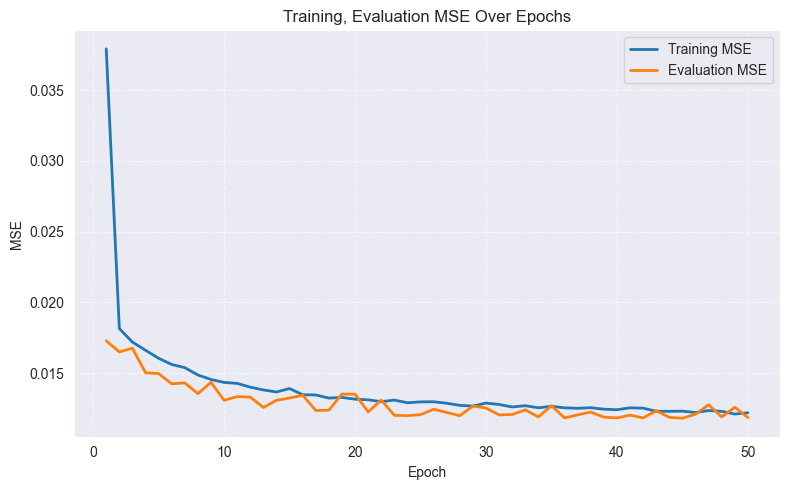

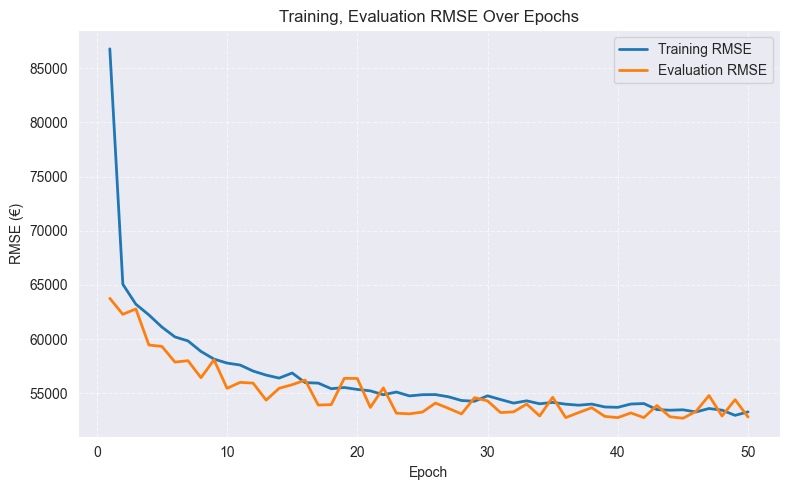

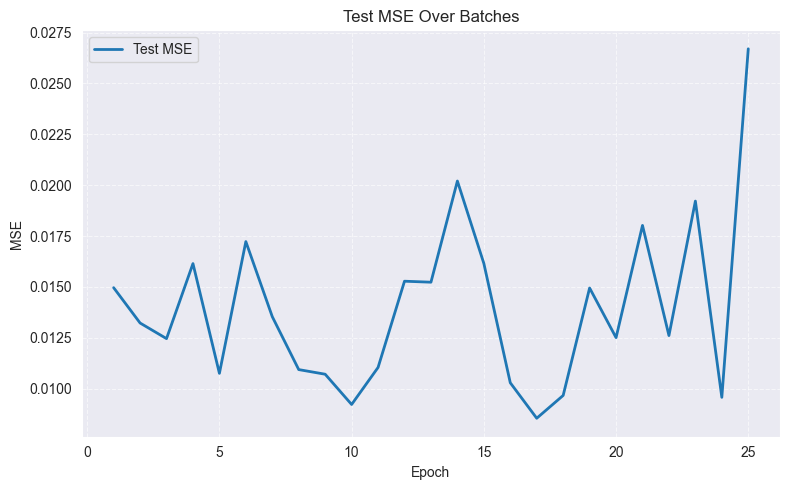

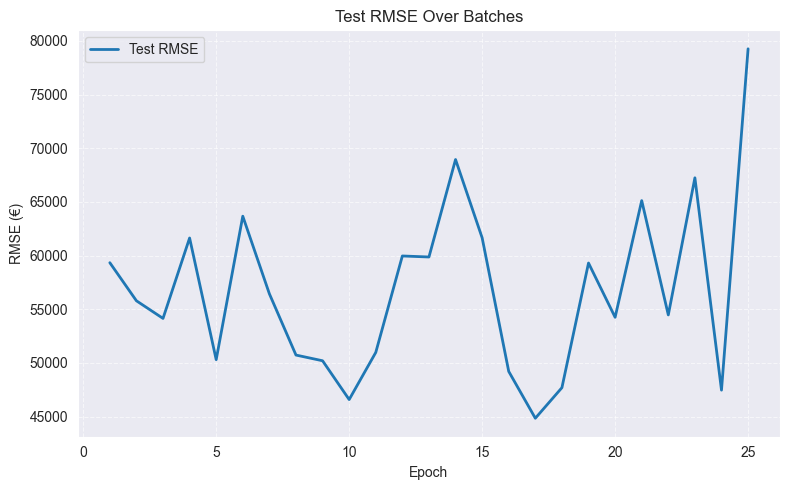

In [16]:
run_experiment(train_loader=train_loader, test_loader=test_loader, eval_loader=eval_loader,tuning=False) #run sample experiment
run_id += 1

### 1.10 Hyperparameter tuning

In [36]:
def hyperparameter_tuning(train_set: CSVDataset):
    run_id = 0
    best_rmse = float("inf")
    best_config = None
    csv_file = "tuning_results.csv"
    
    #create file if it does not exist
    if not os.path.exists(csv_file):
        with open(csv_file, mode="w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                "iteration", "activation", "optimizer", "lr",
                "weight_decay", "batch_size", "train_RMSE", "test_RMSE", "new_best"
            ])
    
    
    
    activation_options = [nn.ReLU, lambda: nn.LeakyReLU(0.1)]
    optimizer_options = ['Adam', 'SGD']
    learning_rates = {
        'Adam': [1e-4, 3e-4, 1e-3],
        'SGD': [1e-2, 3e-3, 1e-3]
    }
    batch_sizes = [64, 128]
    weight_decays = [0, 1e-4]

    param_grid = list(itertools.product(
        activation_options,
        optimizer_options,
        batch_sizes,
        weight_decays
    ))

    total_runs = sum(len(learning_rates[o]) for _, o, _, _ in param_grid)
    print(f"Starting hyperparameter tuning: {total_runs} total runs\n")

    #for effectivity, lets init all needed data loaders needed for experiments
    loaders = []
    for b in batch_sizes:
        train_loader, test_loader, eval_loader = create_loaders(b)
        loaders.append([train_loader, test_loader, eval_loader]) #index of b in batch_sizes

    for act_fn, opt_name, batch, wd in param_grid:
        loader_idx = batch_sizes.index(batch)
        for lr in learning_rates[opt_name]:
            activation = act_fn()
            model = SimpleNN_Res(train_set.X.shape[1]).to(device)
            model.act1 = activation
            model.act2 = activation
            model.act3 = activation

            #optimizer
            if opt_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            elif opt_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
            
            exp_name = f"{dataset_used}_parameter_tuning_{run_id}"
            config_dict = {
                "activation": act_fn.__name__ if hasattr(act_fn, "__name__") else "LeakyReLU(0.1)",
                "batch_size": batch,
                "epoch": EPOCH,
                "lr": lr,
                "loss_fn": "MSELoss",
                "dataset_path": path,
                "optimizer": opt_name,
                "weight_decay": wd
            }
            
            print(f"[{run_id+1}/{total_runs}] Starting: "
                  f"{config_dict['optimizer']} | act={config_dict['activation']} | "
                  f"lr={lr} | wd={wd} | batch={batch}")
            
            
            train_rmse, test_rmse = run_experiment(model=model, optimizer=optimizer, train_loader=loaders[loader_idx][0], test_loader=loaders[loader_idx][1], eval_loader=loaders[loader_idx][2], tuning=True, tuning_param=[exp_name,config_dict])
            
            new_best = False #if it the new best model yet
            if test_rmse < best_rmse:
                best_rmse = test_rmse
                best_config = config_dict
                new_best = True
                print(f"New best RMSE: {best_rmse:.4f} with config {best_config}")
                
                
            #write results to csv
            with open(csv_file, mode="a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([run_id+1, config_dict["activation"], opt_name, lr, wd, batch, train_rmse, test_rmse,new_best])
            
            run_id += 1
    
    if best_config is not None:
        with open("best_config.json", "w") as f:
            json.dump({"best_rmse": best_rmse, "config": best_config}, f, indent=4)
        print(f"\nBest configuration saved to best_config.json:")
        print(json.dumps(best_config, indent=4))
    else:
        print("No valid configuration found!")


In [ ]:
hyperparameter_tuning(train_df) #start hyperparameter tuning

### 1.11 Best Model Results

Best RMSE: 53968.44942545371
Config: {'activation': 'LeakyReLU(0.1)', 'batch_size': 64, 'epoch': 50, 'lr': 0.001, 'loss_fn': 'MSELoss', 'dataset_path': 'data/transformed/full_features', 'optimizer': 'Adam', 'weight_decay': 0}



====TRAINING====
Epoch 001: train RMSE=69120.5505, eval RMSE=60433.4708
Epoch 002: train RMSE=60969.3431, eval RMSE=62986.0227
Epoch 003: train RMSE=59116.0639, eval RMSE=56856.8395
Epoch 004: train RMSE=57857.6931, eval RMSE=56626.4777
Epoch 005: train RMSE=57084.3409, eval RMSE=55418.1893
Epoch 006: train RMSE=56579.9009, eval RMSE=58706.8994
Epoch 007: train RMSE=56249.7847, eval RMSE=55395.9182
Epoch 008: train RMSE=55273.2552, eval RMSE=55436.0674
Epoch 009: train RMSE=55211.5745, eval RMSE=53945.3642
Epoch 010: train RMSE=54938.2797, eval RMSE=57311.6744
Epoch 011: train RMSE=54666.5526, eval RMSE=54343.2044
Epoch 012: train RMSE=54283.2024, eval RMSE=53267.5616
Epoch 013: train RMSE=54049.1694, eval RMSE=54139.4533
Epoch 014: train RMSE=54133.8504, eval RMSE=55914.8327
Epoch 015: train RMSE=53695.2251, eval RMSE=52894.1855
Epoch 016: train RMSE=53347.0426, eval RMSE=53301.9755
Epoch 017: train RMSE=53583.1225, eval RMSE=54013.1972
Epoch 018: train RMSE=52999.2344, eval RMSE=524

batch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
eval_MSE,▆█▄▄▃▃▃▃▄▃▃▄▂▂▂▂▂▂▁▃▂▃▁▁▁▃▂▁▂▁▂▁▁▂▂▁▁▁▁▁
eval_RMSE,▆█▄▄▄▃▄▃▅▃▃▄▂▃▂▂▂▃▂▃▂▃▁▂▁▄▂▁▂▁▂▁▁▂▂▂▁▁▁▁
test_MSE,▄▄▄▃▃▃▃▄▄█▄▃▄▄▄▆▄▃▃▄▃▄▅▄▂▂▃▄▄▄▃▆▅▄▃▅▄▃▄▁
test_RMSE,▅▅▅▄▄▄▄▅▅█▅▄▅▅▅▇▅▄▄▅▄▄▅▅▃▃▄▅▅▅▃▄▆▆▅▄▆▄▅▁
train_MSE,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_RMSE,█▅▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
batch,49
epoch,50
eval_MSE,0.01127


Train RMSE: 48354.8472, Test RMSE: 54237.3468


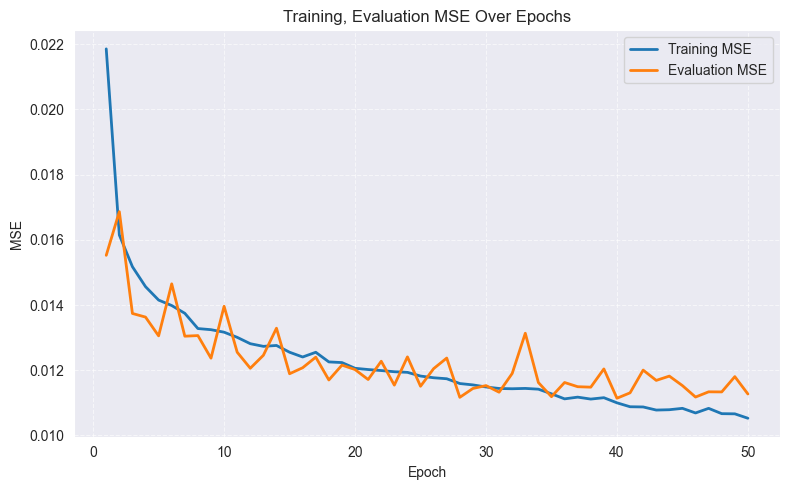

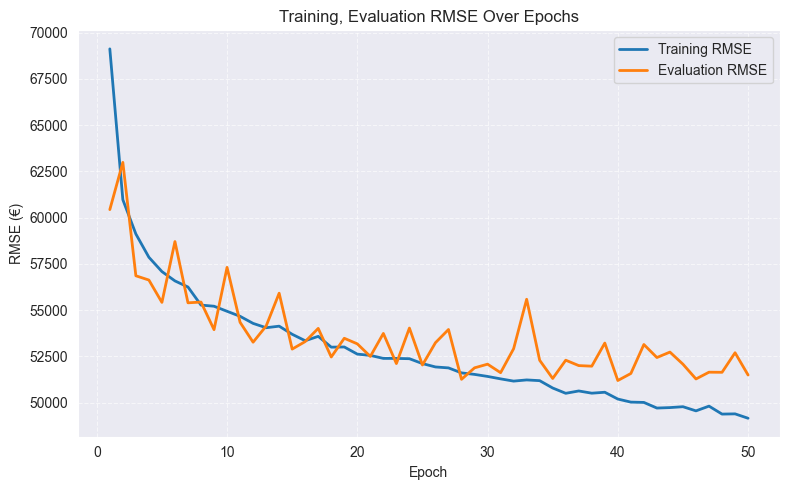

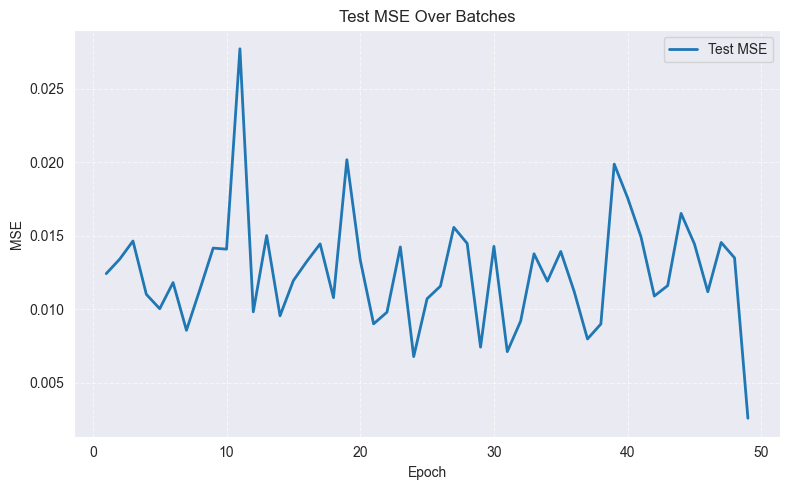

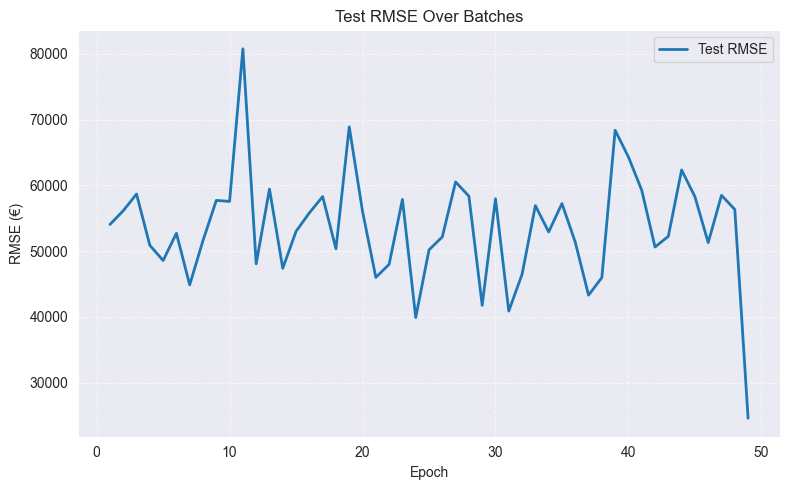

In [39]:
with open("models_tuning/best_config.json", "r") as f: #load best config
    best = json.load(f)

best_rmse = best["best_rmse"]
config = best["config"]
print(f"Best RMSE: {best_rmse}")
print("Config:", config)

#create model
model = SimpleNN_Res(train_df.X.shape[1]).to(device)

#create activation function
activation = nn.LeakyReLU(0.1)

#apply activation
model.act1 = activation
model.act2 = activation
model.act3 = activation

#create optimizer
lr = config["lr"]
weight_decay = config["weight_decay"]

if config["optimizer"] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


#create loader
batch_size = config["batch_size"]
train_loader, test_loader, eval_loader = create_loaders(batch_size)

#run experiment
train_rmse, test_rmse = run_experiment(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    eval_loader=eval_loader,
    tuning=False #print results also
)